In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Importamos las librerías.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next r

In [3]:
# Importamos W&B.
import wandb
from wandb.integration.keras import WandbCallback

In [4]:
# Inicializamos wandb
wandb.init(
    project="Reconocimiento MNIST",
    name="Experimento 3",    
    config={
        "learning_rate": 0.005,
        "epochs": 8,
        "batch_size": 256,
        "optimizer": "adam"
    }
)
config = wandb.config

wandb: Currently logged in as: emilio-soto (emilio-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
# Importamos la base de datos de imágenes.
dataset=mnist.load_data()

# Separamos los datos en entranmiento y prueba
(x_train, y_train), (x_test, y_test) = dataset

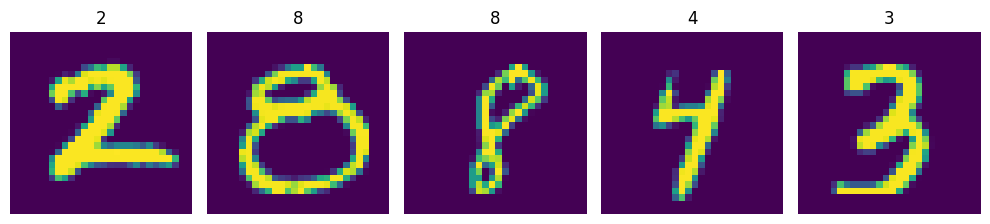

In [6]:
# Vemos el contenido de la base de datos.
# Generamos un conjunto de 5 números aleatorios.
indices_aleatorios = random.sample(range(len(x_train)), 5)

plt.figure(figsize=(10, 5)) # Configuramos el tamaño de la gráfica.

for i, indice in enumerate(indices_aleatorios):
    ax = plt.subplot(1, 5, i + 1) # Queremos 1 renglón, 5 columnas y graficar 5 imágenes.
    plt.imshow(x_train[indice]) # Gráficamos la i-ésima imagen.
    plt.title(y_train[indice]) # Enseñamos que número es el mostrado.
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# Mostramos la forma de los conjuntos.
print("Forma de datos de entrenamiento: ", x_train.shape)
print("Forma de etiquetas de entrenamiento: ", y_train.shape)
print("Forma de datos de prueba: ", x_test.shape)
print("Forma de etiquetas de prueba: ", y_test.shape)

Forma de datos de entrenamiento:  (60000, 28, 28)
Forma de etiquetas de entrenamiento:  (60000,)
Forma de datos de prueba:  (10000, 28, 28)
Forma de etiquetas de prueba:  (10000,)


In [8]:
# Aplanamos las imagenes de la base de datos.
# La matriz de píxeles la pasamos a un vector fila.
x_trainv = x_train.reshape(60000, 784)
x_testv = x_test.reshape(10000, 784)

# Convertimos los valores de los vectores a números flotantes de 32 bits.
# (4 bytes)
x_trainv = x_trainv.astype('float32')
x_testv = x_testv.astype('float32')

# Escalamos los valores de los vectores (es decir, de los píxeles de la imagen)
# a un rango de [0, 1] para mejorar el entrenamiento de la red.
x_trainv /= 255.
x_testv /= 255.

In [9]:
# Damos el número de clases.
num_classes=10

# Convertimos etiquetas númericas a one hot encoding.
y_trainc = keras.utils.to_categorical(y_train, num_classes)
y_testc = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# Valores de hiperparámetros.
learning_rate = config.learning_rate # Valor de la tasa de aprendizaje.
epochs = config.epochs # Número de épocas.
batch_size = config.batch_size # Número de imágenes que usará cada paso.

In [11]:
# Creamos la red neuronal
model = Sequential()
# Colocamos 784 neuronas de entrada y una capa oculta de 30.
model.add(Dense(50, activation='tanh', input_shape=(784,)))
# Colocamos 10 neuronas de sálida.
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compilación del modelo.
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [13]:
# Entrenamiento de la red.
history = model.fit(
    x_trainv, y_trainc,
    batch_size=config.batch_size,
    epochs=config.epochs,
    validation_data=(x_testv, y_testc),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]   
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9048 - loss: 0.3270 - val_accuracy: 0.9424 - val_loss: 0.1931
Epoch 2/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9514 - loss: 0.1661 - val_accuracy: 0.9556 - val_loss: 0.1488
Epoch 3/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9628 - loss: 0.1259 - val_accuracy: 0.9582 - val_loss: 0.1332
Epoch 4/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9701 - loss: 0.1007 - val_accuracy: 0.9633 - val_loss: 0.1176
Epoch 5/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9733 - loss: 0.0871 - val_accuracy: 0.9656 - val_loss: 0.1133
Epoch 6/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9776 - loss: 0.0738 - val_accuracy: 0.9670 - val_loss: 0.1148
Epoch 7/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9813 - loss: 0.0635 - val_accuracy: 0.9654 - val_loss: 0.1186
Epoch 8/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9829 - loss: 0.0575 - val_accuracy: 0.9647 - 

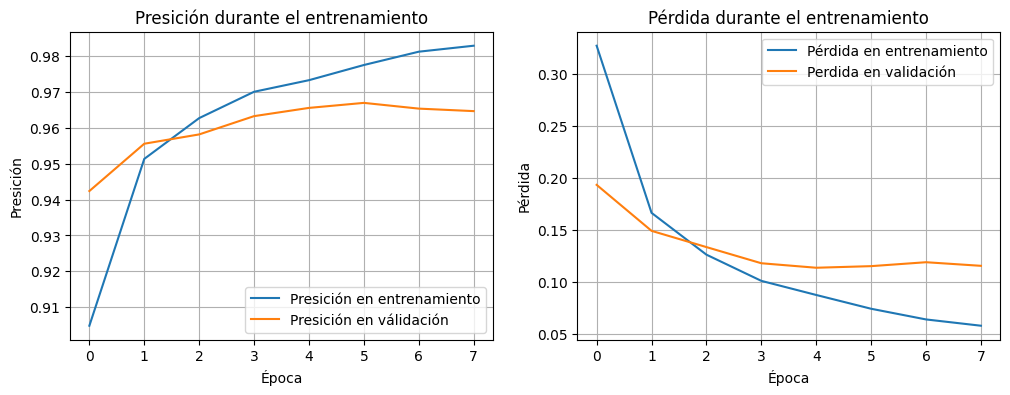

In [14]:
## Gráfica de presición durante el entrenamiento
plt.figure(figsize=(12, 4)) 
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Presición en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Presición en válidación')
plt.title('Presición durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Presición')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2) ## Gráfica de pérdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()